Examples of how one extra feature allows to effectively use KMeans on unusual data:  
https://juanitorduz.github.io/spectral_clustering/ - See the Final Remarks section

In [57]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib
import itertools
import itertools
import math
import time
from copy import deepcopy
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import SpectralClustering
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, QuantileTransformer
import tsfresh.feature_extraction.feature_calculators as fc
# https://tsfresh.readthedocs.io/en/latest/text/list_of_features.html
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from sklearn.manifold import TSNE
plt.style.use('fivethirtyeight')
%matplotlib inline
#%matplotlib notebook
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

In [2]:
# READ IN DATA
df_original = pd.read_csv('./data/norphlet_subset_moving_window_additional_features_20200704.csv', encoding='utf8',
                dtype={'wellname': str, 'field': str,  'field_part': str, 'filename' : str,
                       'wellname_old': str, 'dataset_name': str, 'depth_range': str})

df_original = df_original[[c for c in df_original.columns if 'Unnamed' not in c]]

In [3]:
# MAIN FEATURES
corr_features = ['density_g_cm3', 'rdeep_ohm_m', 'gr_gapi', 'neutron_cfcf', 'nmr_ff_vv', 'nmr_tpor_vv', 'dt']

In [8]:
# THESE FEATURES ARE CORRELATED WITH NMR_TPOR AND NMR_FF
nmrtpor_features = ['dt_absolute_sum_of_changes', 'dt_cid_ce', 'dt_mean_abs_change', 'dt_standard_deviation', 'dt_variance',
                    'dt_variation_coefficient', 'gr_gapi_absolute_sum_of_changes', 'gr_gapi_cid_ce', 'gr_gapi_maximum',
                    'gr_gapi_mean_abs_change', 'gr_gapi_standard_deviation', 'gr_gapi_variance',
                    'gr_gapi_variation_coefficient', 'neutron_cfcf_abs_energy', 'rdeep_ohm_m_abs_energy',
                    'rdeep_ohm_m_absolute_sum_of_changes', 'rdeep_ohm_m_cid_ce', 'rdeep_ohm_m_mean_abs_change',
                    'rdeep_ohm_m_minimum', 'rdeep_ohm_m_standard_deviation', 'rdeep_ohm_m_variance']

nmrff_features   = ['density_g_cm3_abs_energy','dt_abs_energy','dt_absolute_sum_of_changes','dt_cid_ce','dt_mean_abs_change',
                    'dt_minimum', 'gr_gapi_absolute_sum_of_changes', 'gr_gapi_cid_ce', 'gr_gapi_maximum',
                    'gr_gapi_mean_abs_change','gr_gapi_standard_deviation','gr_gapi_variance','gr_gapi_variation_coefficient',
                    'neutron_cfcf_abs_energy', 'rdeep_ohm_m_minimum']


# THESE FEATURES ARE CORRELATED WITH OTHER 5 MAIN FEATURES (NOT NMT_TPOR OR NMR_FF)
other_features   = ['density_g_cm3_minimum', 'dt_maximum', 'dt_mean', 'dt_sum_values', 'gr_gapi_minimum',
                    'neutron_cfcf_absolute_sum_of_changes', 'neutron_cfcf_cid_ce',
                    'neutron_cfcf_maximum', 'neutron_cfcf_mean_abs_change']


# NMR_TPOR AND NMR_FF SUBFEATURES CORRELATED WITH OTHER MAIN FEATURES
nmrtpor_sub      = ['nmr_tpor_vv_cid_ce', 'nmr_tpor_vv_mean_abs_change', 'nmr_tpor_vv_absolute_sum_of_changes',
                    'nmr_tpor_vv_longest_strike_below_mean']

nmrff_sub        = ['nmr_ff_vv_cid_ce', 'nmr_ff_vv_mean_abs_change', 'nmr_ff_vv_absolute_sum_of_changes',
                    'nmr_ff_vv_longest_strike_below_mean']

additional_features = sorted(list(set(nmrtpor_features + nmrff_features + other_features + nmrtpor_sub + nmrff_sub)))
print('Length of additional features:', len(additional_features))

Length of additional features: 41


In [5]:
print(df_original.shape)
df_original.head()

(14273, 248)


,wellname,field,field_part,md_ft,density_g_cm3,dtc_us_ft,dts_us_ft,fluid,gr_gapi,neutron_cfcf,nmr_bw_vv,nmr_cbw_vv,nmr_ff_vv,nmr_tpor_vv,rdeep_ohm_m,tvd_ft,tvdbml_ft,tvdss_ft,filename,wellname_old,dataset_name,rmedium_ohm_m,rshallow_ohm_m,dt,density_g_cm3_abs_energy,density_g_cm3_absolute_sum_of_changes,density_g_cm3_cid_ce,density_g_cm3_count_above_mean,density_g_cm3_count_below_mean,density_g_cm3_first_location_of_maximum,density_g_cm3_first_location_of_minimum,density_g_cm3_last_location_of_maximum,density_g_cm3_last_location_of_minimum,density_g_cm3_has_duplicate_max,density_g_cm3_has_duplicate_min,density_g_cm3_kurtosis,density_g_cm3_longest_strike_above_mean,density_g_cm3_longest_strike_below_mean,density_g_cm3_minimum,density_g_cm3_maximum,density_g_cm3_mean,density_g_cm3_median,density_g_cm3_mean_change,density_g_cm3_mean_abs_change,density_g_cm3_mean_second_derivative_central,density_g_cm3_percentage_of_reoccurring_datapoints_to_all_datapoints,density_g_cm3_ratio_beyond_r_sigma,density_g_cm3_ratio_value_number_to_time_series_length,density_g_cm3_sample_entropy,density_g_cm3_skewness,density_g_cm3_standard_deviation,density_g_cm3_sum_of_reoccurring_data_points,density_g_cm3_sum_of_reoccurring_values,density_g_cm3_sum_values,density_g_cm3_variance,density_g_cm3_variation_coefficient,rdeep_ohm_m_abs_energy,rdeep_ohm_m_absolute_sum_of_changes,rdeep_ohm_m_cid_ce,rdeep_ohm_m_count_above_mean,rdeep_ohm_m_count_below_mean,rdeep_ohm_m_first_location_of_maximum,rdeep_ohm_m_first_location_of_minimum,rdeep_ohm_m_last_location_of_maximum,rdeep_ohm_m_last_location_of_minimum,rdeep_ohm_m_has_duplicate_max,rdeep_ohm_m_has_duplicate_min,rdeep_ohm_m_kurtosis,rdeep_ohm_m_longest_strike_above_mean,rdeep_ohm_m_longest_strike_below_mean,rdeep_ohm_m_minimum,rdeep_ohm_m_maximum,rdeep_ohm_m_mean,rdeep_ohm_m_median,rdeep_ohm_m_mean_change,rdeep_ohm_m_mean_abs_change,rdeep_ohm_m_mean_second_derivative_central,rdeep_ohm_m_percentage_of_reoccurring_datapoints_to_all_datapoints,rdeep_ohm_m_ratio_beyond_r_sigma,rdeep_ohm_m_ratio_value_number_to_time_series_length,rdeep_ohm_m_sample_entropy,rdeep_ohm_m_skewness,rdeep_ohm_m_standard_deviation,rdeep_ohm_m_sum_of_reoccurring_data_points,rdeep_ohm_m_sum_of_reoccurring_values,rdeep_ohm_m_sum_values,rdeep_ohm_m_variance,rdeep_ohm_m_variation_coefficient,gr_gapi_abs_energy,gr_gapi_absolute_sum_of_changes,gr_gapi_cid_ce,gr_gapi_count_above_mean,gr_gapi_count_below_mean,gr_gapi_first_location_of_maximum,gr_gapi_first_location_of_minimum,gr_gapi_last_location_of_maximum,gr_gapi_last_location_of_minimum,gr_gapi_has_duplicate_max,gr_gapi_has_duplicate_min,gr_gapi_kurtosis,gr_gapi_longest_strike_above_mean,gr_gapi_longest_strike_below_mean,gr_gapi_minimum,gr_gapi_maximum,gr_gapi_mean,gr_gapi_median,gr_gapi_mean_change,gr_gapi_mean_abs_change,gr_gapi_mean_second_derivative_central,gr_gapi_percentage_of_reoccurring_datapoints_to_all_datapoints,gr_gapi_ratio_beyond_r_sigma,gr_gapi_ratio_value_number_to_time_series_length,gr_gapi_sample_entropy,gr_gapi_skewness,gr_gapi_standard_deviation,gr_gapi_sum_of_reoccurring_data_points,gr_gapi_sum_of_reoccurring_values,gr_gapi_sum_values,gr_gapi_variance,gr_gapi_variation_coefficient,neutron_cfcf_abs_energy,neutron_cfcf_absolute_sum_of_changes,neutron_cfcf_cid_ce,neutron_cfcf_count_above_mean,neutron_cfcf_count_below_mean,neutron_cfcf_first_location_of_maximum,neutron_cfcf_first_location_of_minimum,neutron_cfcf_last_location_of_maximum,neutron_cfcf_last_location_of_minimum,neutron_cfcf_has_duplicate_max,neutron_cfcf_has_duplicate_min,neutron_cfcf_kurtosis,neutron_cfcf_longest_strike_above_mean,neutron_cfcf_longest_strike_below_mean,neutron_cfcf_minimum,neutron_cfcf_maximum,neutron_cfcf_mean,neutron_cfcf_median,neutron_cfcf_mean_change,neutron_cfcf_mean_abs_change,neutron_cfcf_mean_second_derivative_central,neutron_cfcf_percentage_of_reoccurring_datapoints_to_all_datapoints,neutron_cfcf_ratio_beyond_r_sigma,neutron_cfcf_ratio_value_number_to_time_series_length,neutron_cfcf_sam

In [6]:
df_original['wellname'].unique()

array(['MC348-3ST1', 'MC391-1', 'MC392-1', 'MC392-1ST1', 'MC393-1',
       'MC525-2', 'MC612-1BP1'], dtype=object)

In [9]:
df_original[corr_features + additional_features].isna().sum()

density_g_cm3                            0
rdeep_ohm_m                              0
gr_gapi                                  0
neutron_cfcf                             0
nmr_ff_vv                                0
nmr_tpor_vv                              0
dt                                       0
density_g_cm3_abs_energy                 0
density_g_cm3_minimum                    0
dt_abs_energy                            0
dt_absolute_sum_of_changes               0
dt_cid_ce                                0
dt_maximum                               0
dt_mean                                  0
dt_mean_abs_change                       0
dt_minimum                               0
dt_standard_deviation                    0
dt_sum_values                            0
dt_variance                              0
dt_variation_coefficient                 0
gr_gapi_absolute_sum_of_changes          0
gr_gapi_cid_ce                           0
gr_gapi_maximum                          0
gr_gapi_mea

In [10]:
# DATA POINTS PER WELL
print('Data points per well:')
for well in df_original['wellname'].unique():
    print('\t{}: {} datapoints'.format(well, df_original[df_original['wellname'] == well].shape[0]))

Data points per well:
	MC348-3ST1: 551 datapoints
	MC391-1: 2713 datapoints
	MC392-1: 950 datapoints
	MC392-1ST1: 3032 datapoints
	MC393-1: 3679 datapoints
	MC525-2: 1173 datapoints
	MC612-1BP1: 2175 datapoints


In [11]:
# OIL = 2, WATER = 1
df_original['fluid'].value_counts()

2.0    12516
1.0     1757
Name: fluid, dtype: int64

In [14]:
# DATA POINTS PER WELL IN OIL
print('Data points per well in oil:')
for well in df_original['wellname'].unique():
    print('\t{}: {} datapoints'.format(well, df_original[(df_original['wellname'] == well) & (df_original['fluid'] == 2)].shape[0]))

Data points per well in oil:
	MC348-3ST1: 551 datapoints
	MC391-1: 2713 datapoints
	MC392-1: 950 datapoints
	MC392-1ST1: 3032 datapoints
	MC393-1: 2709 datapoints
	MC525-2: 874 datapoints
	MC612-1BP1: 1687 datapoints


#### Only the last three wells have water

In [15]:
print('Min depth:', df_original['tvdss_ft'].min())
print('Max depth:', df_original['tvdss_ft'].max())
print('Difference:', math.ceil(df_original['tvdss_ft'].max() - df_original['tvdss_ft'].min()))

Min depth: 24320.04
Max depth: 28559.0401761094
Difference: 4240


In [16]:
# ZERO DUPLICATES
df_original[df_original[corr_features + additional_features].duplicated()]

,wellname,field,field_part,md_ft,density_g_cm3,dtc_us_ft,dts_us_ft,fluid,gr_gapi,neutron_cfcf,nmr_bw_vv,nmr_cbw_vv,nmr_ff_vv,nmr_tpor_vv,rdeep_ohm_m,tvd_ft,tvdbml_ft,tvdss_ft,filename,wellname_old,dataset_name,rmedium_ohm_m,rshallow_ohm_m,dt,density_g_cm3_abs_energy,density_g_cm3_absolute_sum_of_changes,density_g_cm3_cid_ce,density_g_cm3_count_above_mean,density_g_cm3_count_below_mean,density_g_cm3_first_location_of_maximum,density_g_cm3_first_location_of_minimum,density_g_cm3_last_location_of_maximum,density_g_cm3_last_location_of_minimum,density_g_cm3_has_duplicate_max,density_g_cm3_has_duplicate_min,density_g_cm3_kurtosis,density_g_cm3_longest_strike_above_mean,density_g_cm3_longest_strike_below_mean,density_g_cm3_minimum,density_g_cm3_maximum,density_g_cm3_mean,density_g_cm3_median,density_g_cm3_mean_change,density_g_cm3_mean_abs_change,density_g_cm3_mean_second_derivative_central,density_g_cm3_percentage_of_reoccurring_datapoints_to_all_datapoints,density_g_cm3_ratio_beyond_r_sigma,density_g_cm3_ratio_value_number_to_time_series_length,density_g_cm3_sample_entropy,density_g_cm3_skewness,density_g_cm3_standard_deviation,density_g_cm3_sum_of_reoccurring_data_points,density_g_cm3_sum_of_reoccurring_values,density_g_cm3_sum_values,density_g_cm3_variance,density_g_cm3_variation_coefficient,rdeep_ohm_m_abs_energy,rdeep_ohm_m_absolute_sum_of_changes,rdeep_ohm_m_cid_ce,rdeep_ohm_m_count_above_mean,rdeep_ohm_m_count_below_mean,rdeep_ohm_m_first_location_of_maximum,rdeep_ohm_m_first_location_of_minimum,rdeep_ohm_m_last_location_of_maximum,rdeep_ohm_m_last_location_of_minimum,rdeep_ohm_m_has_duplicate_max,rdeep_ohm_m_has_duplicate_min,rdeep_ohm_m_kurtosis,rdeep_ohm_m_longest_strike_above_mean,rdeep_ohm_m_longest_strike_below_mean,rdeep_ohm_m_minimum,rdeep_ohm_m_maximum,rdeep_ohm_m_mean,rdeep_ohm_m_median,rdeep_ohm_m_mean_change,rdeep_ohm_m_mean_abs_change,rdeep_ohm_m_mean_second_derivative_central,rdeep_ohm_m_percentage_of_reoccurring_datapoints_to_all_datapoints,rdeep_ohm_m_ratio_beyond_r_sigma,rdeep_ohm_m_ratio_value_number_to_time_series_length,rdeep_ohm_m_sample_entropy,rdeep_ohm_m_skewness,rdeep_ohm_m_standard_deviation,rdeep_ohm_m_sum_of_reoccurring_data_points,rdeep_ohm_m_sum_of_reoccurring_values,rdeep_ohm_m_sum_values,rdeep_ohm_m_variance,rdeep_ohm_m_variation_coefficient,gr_gapi_abs_energy,gr_gapi_absolute_sum_of_changes,gr_gapi_cid_ce,gr_gapi_count_above_mean,gr_gapi_count_below_mean,gr_gapi_first_location_of_maximum,gr_gapi_first_location_of_minimum,gr_gapi_last_location_of_maximum,gr_gapi_last_location_of_minimum,gr_gapi_has_duplicate_max,gr_gapi_has_duplicate_min,gr_gapi_kurtosis,gr_gapi_longest_strike_above_mean,gr_gapi_longest_strike_below_mean,gr_gapi_minimum,gr_gapi_maximum,gr_gapi_mean,gr_gapi_median,gr_gapi_mean_change,gr_gapi_mean_abs_change,gr_gapi_mean_second_derivative_central,gr_gapi_percentage_of_reoccurring_datapoints_to_all_datapoints,gr_gapi_ratio_beyond_r_sigma,gr_gapi_ratio_value_number_to_time_series_length,gr_gapi_sample_entropy,gr_gapi_skewness,gr_gapi_standard_deviation,gr_gapi_sum_of_reoccurring_data_points,gr_gapi_sum_of_reoccurring_values,gr_gapi_sum_values,gr_gapi_variance,gr_gapi_variation_coefficient,neutron_cfcf_abs_energy,neutron_cfcf_absolute_sum_of_changes,neutron_cfcf_cid_ce,neutron_cfcf_count_above_mean,neutron_cfcf_count_below_mean,neutron_cfcf_first_location_of_maximum,neutron_cfcf_first_location_of_minimum,neutron_cfcf_last_location_of_maximum,neutron_cfcf_last_location_of_minimum,neutron_cfcf_has_duplicate_max,neutron_cfcf_has_duplicate_min,neutron_cfcf_kurtosis,neutron_cfcf_longest_strike_above_mean,neutron_cfcf_longest_strike_below_mean,neutron_cfcf_minimum,neutron_cfcf_maximum,neutron_cfcf_mean,neutron_cfcf_median,neutron_cfcf_mean_change,neutron_cfcf_mean_abs_change,neutron_cfcf_mean_second_derivative_central,neutron_cfcf_percentage_of_reoccurring_datapoints_to_all_datapoints,neutron_cfcf_ratio_beyond_r_sigma,neutron_cfcf_ratio_value_number_to_time_series_length,neutron_cfcf_sam

In [332]:
# nmrtpor_features + nmrff_features + other_features + nmrtpor_sub + nmrff_sub
select_features = sorted(list(set(nmrtpor_features + nmrff_features + nmrtpor_sub + nmrff_sub)))
all_features = corr_features + select_features
print('Length of all features:', len(all_features))

Length of all features: 39


In [333]:
# KEEP THE ORIGINAL DATA
df = deepcopy(df_original)
standard_scaler = StandardScaler()
minmax_scaler   = MinMaxScaler()
df[all_features] = standard_scaler.fit_transform(df[all_features])

## OPTIMAL K

noisy = deepcopy(df[all_features])
print(noisy.shape)
explained_var = 0.95
pca = PCA(explained_var).fit(noisy)
print('# componenets for explained variance {}: {}'.format(explained_var, pca.n_components_))

filtered = pca.transform(noisy)
#filtered = pca.inverse_transform(components)
data = pd.DataFrame(filtered)
data.head()

Shape of data: (14273, 39)


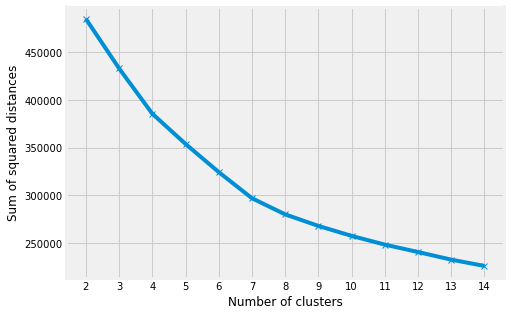

In [334]:
# find optimal number of clusters - elbow method - for optimal combination of features
%matplotlib inline

data = deepcopy(df[all_features])
print('Shape of data:', data.shape)
   
Sum_of_squared_distances = []
K = range(2, 15)
for k in K:    
    km = KMeans(n_clusters=k, n_init=25, max_iter=1000, algorithm='full')        # algorithm='full', 'elkan', tol=0.0001
    km = km.fit(data)
    Sum_of_squared_distances.append(km.inertia_)

plt.figure(figsize=(7,5))
plt.plot(K, Sum_of_squared_distances, 'x-')
plt.xticks(K)
plt.xlabel('Number of clusters')
plt.ylabel('Sum of squared distances')
plt.show()

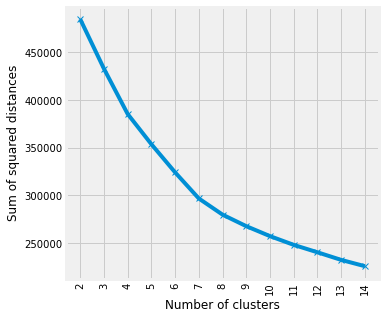

In [335]:
plt.figure(figsize=(5,5))
plt.plot(K, Sum_of_squared_distances, 'x-')
plt.xticks(K, rotation='vertical')
plt.xlabel('Number of clusters')
plt.ylabel('Sum of squared distances')
#plt.title('Well {}: {}'.format(well, ' | '.join(comb)))
plt.show()

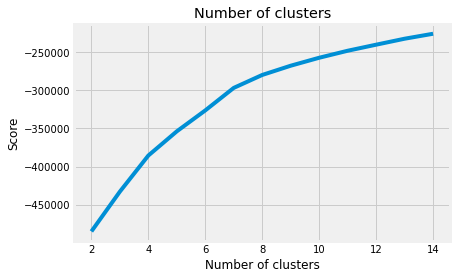

In [336]:
# similar method for k
K = range(2, 15)
kmeans = [KMeans(n_clusters=i, max_iter=1000, algorithm='full', n_init=25) for i in K]
score = [kmeans[i].fit(data).score(data) for i in range(len(kmeans))]

plt.plot(K, score)
plt.xlabel('Number of clusters')
plt.ylabel('Score')
plt.title('Number of clusters')
plt.show()

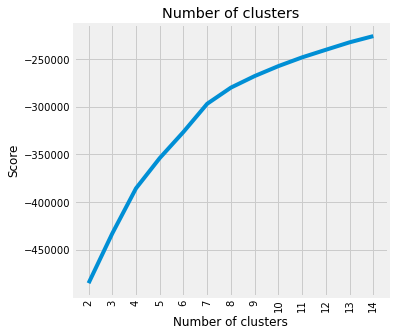

In [337]:
plt.figure(figsize=(5,5))
plt.plot(K, score)
plt.xticks(K, rotation='vertical')
plt.xlabel('Number of clusters')
plt.ylabel('Score')
plt.title('Number of clusters')
plt.show()

In [331]:
df_100clusters = pd.DataFrame({'K': K, 'Squ_dist_sum': Sum_of_squared_distances, 'Scores': score})
df_100clusters.head(20)

NameError: name 'df_100clustersclusters' is not defined

## Visualize with PCA

#### 3D plot
def plot_3d_pca(data, labels, prev_pca):
        
    # dimensionality reduction
    n_clust = len(set(labels.tolist()))
    pca_3 = PCA(3)
    projected = pd.DataFrame(pca_3.fit_transform(data), columns=['pc_1', 'pc_2', 'pc_3'])
    print('PCA_1 vs. orig. Explained variance:', sum(prev_pca.explained_variance_ratio_))
    print('PCA_2 vs. PCA_1 Explained variance:', sum(pca_2.explained_variance_ratio_))
    
    # plotting
    ax = plt.figure(figsize=(10,5)).gca(projection='3d')
    ax.scatter(
        xs=projected['pc_1'], 
        ys=projected['pc_2'], 
        zs=projected['pc_3'], 
        c=labels, 
        cmap='tab10'
    )
    ax.set_xlabel('pc_1')
    ax.set_ylabel('pc_2')
    ax.set_zlabel('pc_3')
    plt.title('PCA 3D Visualization, K-Means w/{} clusters'.format(n_clust))
    plt.tight_layout(pad=0)
    plt.show()

## Visualize with t-SNE

In [95]:
# tSNE takes time, so it should be done once outside of visualization functions
# 2-component tSNE
data_tsne = deepcopy(df[all_features])
time_start = time.time()
tsne2 = TSNE(n_components=2, verbose=1, perplexity=30, n_iter=2500, n_jobs=-1, learning_rate=100.0, early_exaggeration=12.0, 
             n_iter_without_progress=300, metric='euclidean', init='pca')    # init='pca' or 'random'
tsne2_results = tsne2.fit_transform(data_tsne)

data_tsne['tsne2_1'] = tsne2_results[:,0]
data_tsne['tsne2_2'] = tsne2_results[:,1]
print('2-component t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))
tsne2_results = None

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 14273 samples in 0.107s...
[t-SNE] Computed neighbors for 14273 samples in 1.552s...
[t-SNE] Computed conditional probabilities for sample 1000 / 14273
[t-SNE] Computed conditional probabilities for sample 2000 / 14273
[t-SNE] Computed conditional probabilities for sample 3000 / 14273
[t-SNE] Computed conditional probabilities for sample 4000 / 14273
[t-SNE] Computed conditional probabilities for sample 5000 / 14273
[t-SNE] Computed conditional probabilities for sample 6000 / 14273
[t-SNE] Computed conditional probabilities for sample 7000 / 14273
[t-SNE] Computed conditional probabilities for sample 8000 / 14273
[t-SNE] Computed conditional probabilities for sample 9000 / 14273
[t-SNE] Computed conditional probabilities for sample 10000 / 14273
[t-SNE] Computed conditional probabilities for sample 11000 / 14273
[t-SNE] Computed conditional probabilities for sample 12000 / 14273
[t-SNE] Computed conditional probabilities for sam

In [96]:
# 3-component tSNE
time_start = time.time()
tsne3 = TSNE(n_components=3, verbose=1, perplexity=40, n_iter=300, n_jobs=-1)
tsne3_results = tsne3.fit_transform(data_tsne[all_features])

data_tsne['tsne3_1'] = tsne3_results[:,0]
data_tsne['tsne3_2'] = tsne3_results[:,1]
data_tsne['tsne3_3'] = tsne3_results[:,2]
print('3-component t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))
tsne3_results = None

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 14273 samples in 0.153s...
[t-SNE] Computed neighbors for 14273 samples in 1.916s...
[t-SNE] Computed conditional probabilities for sample 1000 / 14273
[t-SNE] Computed conditional probabilities for sample 2000 / 14273
[t-SNE] Computed conditional probabilities for sample 3000 / 14273
[t-SNE] Computed conditional probabilities for sample 4000 / 14273
[t-SNE] Computed conditional probabilities for sample 5000 / 14273
[t-SNE] Computed conditional probabilities for sample 6000 / 14273
[t-SNE] Computed conditional probabilities for sample 7000 / 14273
[t-SNE] Computed conditional probabilities for sample 8000 / 14273
[t-SNE] Computed conditional probabilities for sample 9000 / 14273
[t-SNE] Computed conditional probabilities for sample 10000 / 14273
[t-SNE] Computed conditional probabilities for sample 11000 / 14273
[t-SNE] Computed conditional probabilities for sample 12000 / 14273
[t-SNE] Computed conditional probabilities for sa

## 2D PCA and tSNE side by side

In [77]:
# 2D PCA and tSNE side by side
def plot_2D_pca_tsne(data_all, data_tsne_local, labels, cmethod='K-Means'):
        
    # do PCA
    data_all = deepcopy(data_all)
    pca_2 = PCA(2)
    projected = pca_2.fit_transform(data_all)
    df_proj = pd.DataFrame(projected, columns=['pc_1', 'pc_2'])
    df_proj['labels'] = labels
    
    data_tsne_local = deepcopy(data_tsne_local)
    data_tsne_local['labels'] = labels

    # plot PCA & tSNE
    n_clust = len(set(labels))
    plt.figure(figsize=(8, 10))
    ax1 = plt.subplot(2, 1, 1)
    ax1.set_title('PCA 2D, {} clusters'.format(cmethod.replace('_', ' '), n_clust))
    sns.scatterplot(
        x="pc_1", y="pc_2",
        hue='labels',
        palette=sns.color_palette("hls", n_clust),
        data=df_proj,
        legend="full",
        alpha=0.3,
        ax=ax1
    )
    ax2 = plt.subplot(2, 1, 2)
    ax2.set_title('tSNE 2D, {} clusters'.format(cmethod.replace('_', ' '), n_clust))
    sns.scatterplot(
        x="tsne2_1", y="tsne2_2",
        hue='labels',
        palette=sns.color_palette("hls", n_clust),
        data=data_tsne_local,
        legend="full",
        alpha=0.3,
        ax=ax2
    )
    plt.tight_layout()

## 3D tSNE

In [78]:
%matplotlib inline
def plot_3d_tsne(data, labels):
    
    # plotting (refresh kernel for %matplotlib notebook)
    ax = plt.figure(figsize=(10,5)).gca(projection='3d')
    ax.scatter(
        xs=data['tsne3_1'], 
        ys=data['tsne3_2'], 
        zs=data['tsne3_3'], 
        c=labels, 
        cmap='tab10'
    )
    ax.set_xlabel('tsne3_1')
    ax.set_ylabel('tsne3_2')
    ax.set_zlabel('tsne3_3')
    plt.tight_layout(pad=0)
    plt.show()

## Visualize which intervals in individual well sections were clustered together
__Repeat clustering for each individual well?!__

In [79]:
def plot_well(df_local, cluster_col, well_name=None):
        
    df_local = deepcopy(df_local[['wellname', 'tvdss_ft', cluster_col]])
    if well_name:
        df_local = df_local[df_local['wellname'] == well_name]
    
    x = df_local['tvdss_ft']
    y = [1 for item in x]
    clusters = df_local[cluster_col]

    df_draw = pd.DataFrame(dict(depth=x, one=y, color=clusters))
    fig, ax = plt.subplots(figsize=(16,2))
    color_map = {0:'tab:green', 1:'tab:orange', 2:'tab:cyan', 3:'tab:pink', 4:'tab:blue', 5:'tab:olive', 6:'tab:gray', 7:'tab:red'}
    ax.scatter(df_draw['depth'], df_draw['one'], c=df_draw['color'].apply(lambda x: color_map[x]), s=3500, marker="|")
        
    clusters_unique = sorted(df_local[cluster_col].unique().tolist())
        
    patchList = []
    for cluster in clusters_unique:
            data_key = mpatches.Patch(color=color_map[cluster], label=cluster)
            patchList.append(data_key)

    plt.legend(handles=patchList, loc='upper right', fontsize=8)    
        
    title = ''
    if well_name:
        title += 'Well ' + well_name + ': '
    else:
        title += 'All wells: '
    title += cluster_col.replace('_', ' ') + ' clusters'
    ax.set_title(title, fontsize=15)
    plt.yticks([])
    plt.show()

### 3, 4 or 5 Clusters

In [97]:
# change n_clusters as needed
n_clusters = 5
data = deepcopy(df[all_features])
km = KMeans(n_clusters=n_clusters, n_init=25, max_iter=1000, algorithm='full', n_jobs=-1)    # 'elkan'
km.fit(data)
print('K-Means Inertia: {} (the smaller the better):'.format(km.inertia_))

K-Means Inertia: 20802.18036625772 (the smaller the better):


In [98]:
km.labels_

array([3, 3, 3, ..., 3, 3, 3])

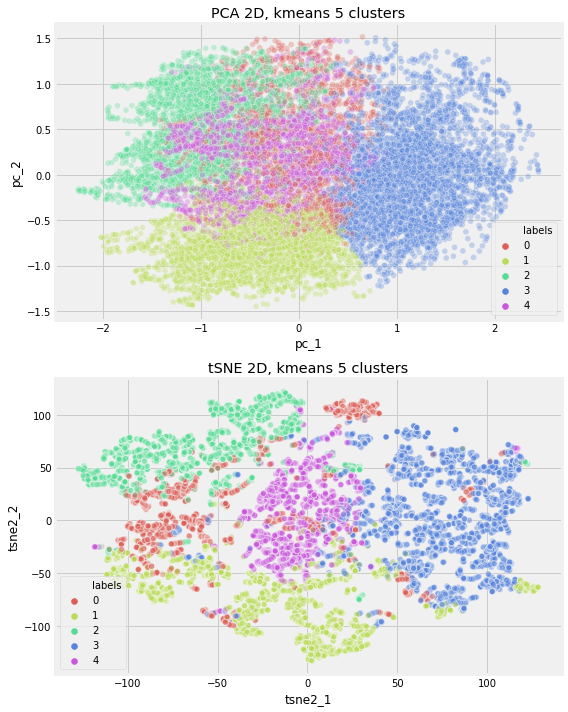

In [99]:
column_name = 'kmeans_' + str(n_clusters)
plot_2D_pca_tsne(data, data_tsne[['tsne2_1', 'tsne2_2']], km.labels_, column_name)

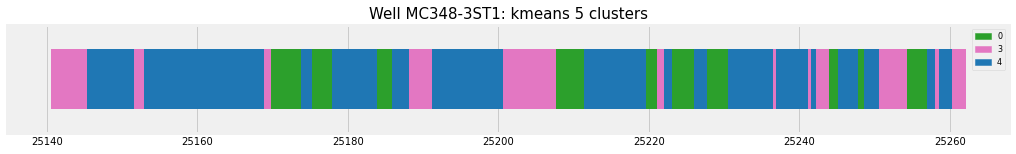

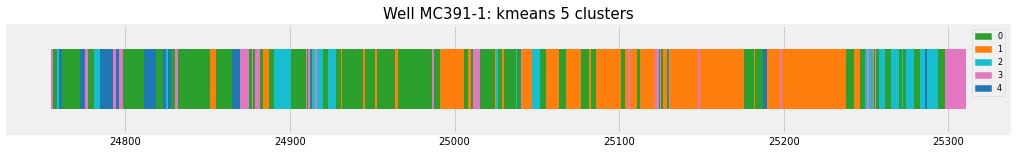

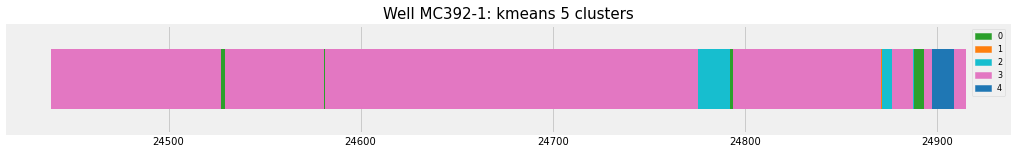

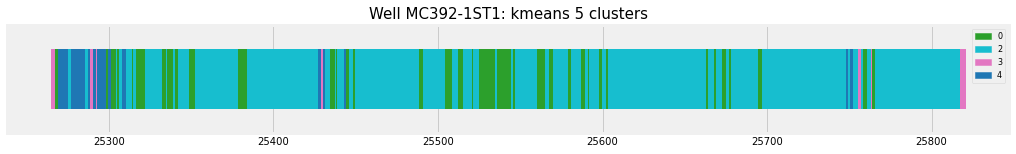

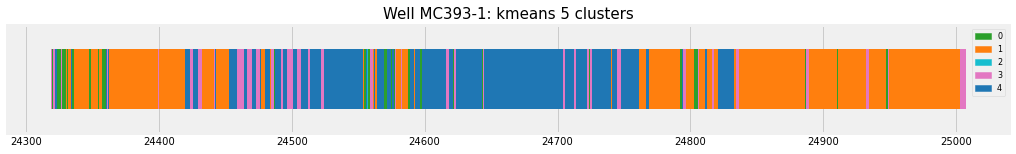

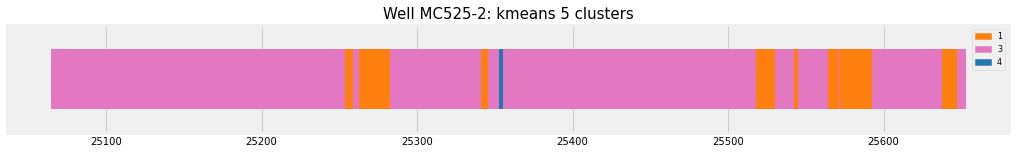

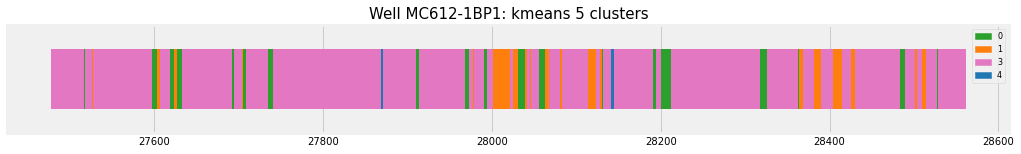

In [100]:
# change df column name to reflect n_clusters
df[column_name] = km.labels_
wells = df['wellname'].unique().tolist()

for well in wells:
    plot_well(df, column_name, well)

### SpectralClustering
Uses the graph of nearest neighbors to compute a higher-dimensional representation of the data, and then assigns labels using a k-means algorithm.

Well diagrams look cleaner, but 'MC348-3ST1' has only 2 clusters when clustering on 4 clusters, and only 3 when clustering on 8 clusters - reasonable? May be because the section begin analyzed in that well is only 120 feet long conpared to over 500 feet in other wells

In [ ]:
data = deepcopy(df[all_features])
sc_n_clusters = 4
model = SpectralClustering(n_clusters=sc_n_clusters, n_init=100, affinity='nearest_neighbors',
                           assign_labels='kmeans', n_jobs=-1) 
sc_labels = model.fit_predict(data)

In [ ]:
column_name = 'spectral_' + str(sc_n_clusters)
plot_2D_pca_tsne(data, data_tsne[['tsne2_1', 'tsne2_2']], sc_labels, column_name)

In [ ]:
df[column_name] = sc_labels
wells = df['wellname'].unique().tolist()

for well in wells:
    plot_well(df, column_name, well)

## Remove noise using PCA

In [ ]:
noisy = deepcopy(df[all_features])
pca = PCA(0.7).fit(noisy)
print(pca.n_components_)
components = pca.transform(noisy)
filtered = pca.inverse_transform(components)
df_filtered = pd.DataFrame(filtered)
df_filtered.head()

In [ ]:
# find optimal number of clusters - elbow method
%matplotlib inline
Sum_of_squared_distances = []
K = range(2, 11, 1)
for k in K:
    data = deepcopy(df_filtered)
    km = KMeans(n_clusters=k, n_init=25, max_iter=1000)
    km = km.fit(data)
    Sum_of_squared_distances.append(km.inertia_)
    
plt.plot(K, Sum_of_squared_distances, 'x-')
plt.xticks(K)
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [ ]:
# clustering
n_clusters = 4
data = deepcopy(df_filtered)
kmd = KMeans(n_clusters=n_clusters, n_init=25, max_iter=1000, algorithm='full', n_jobs=-1)    # 'elkan'
kmd.fit(data)
print('K-Means Inertia: {} (the smaller the better):'.format(kmd.inertia_))

In [ ]:
column_name = 'denoised_' + str(n_clusters)
plot_2D_pca_tsne(data, data_tsne[['tsne2_1', 'tsne2_2']], kmd.labels_, column_name)

In [ ]:
df[column_name] = kmd.labels_
wells = df['wellname'].unique().tolist()

for well in wells:
    plot_well(df, column_name, well)

## Expectation Maximization - fine tune hyperparameters!
sklearn.mixture.GaussianMixture(n_components=1, *, covariance_type='full', tol=0.001, reg_covar=1e-06, max_iter=100, n_init=1, init_params='kmeans', weights_init=None, means_init=None, precisions_init=None, random_state=None, warm_start=False, verbose=0, verbose_interval=10)

BayesianGaussianMixture(*, n_components=1, covariance_type='full', tol=0.001, reg_covar=1e-06, max_iter=100, n_init=1, init_params='kmeans', weight_concentration_prior_type='dirichlet_process', weight_concentration_prior=None, mean_precision_prior=None, mean_prior=None, degrees_of_freedom_prior=None, covariance_prior=None, random_state=None, warm_start=False, verbose=0, verbose_interval=10)

In [ ]:
# try the above visualization too
data = deepcopy(df[all_features])
n_clusters = 4
gm = GaussianMixture(n_clusters, max_iter=500, n_init=10)
gm_labels = gm.fit_predict(data)

In [ ]:
column_name = 'em_' + str(n_clusters)
plot_2D_pca_tsne(data, data_tsne[['tsne2_1', 'tsne2_2']], gm_labels, column_name)

In [ ]:
df[column_name] = gm_labels
wells = df['wellname'].unique().tolist()

for well in wells:
    plot_well(df, column_name, well)

In [ ]:
cols_to_plot = ['kmeans_4', 'denoised_4', 'em_4', 'spectral_4']

for col in cols_to_plot:
    plot_well(df, col)

## DBSCAN
https://medium.com/@elutins/dbscan-what-is-it-when-to-use-it-how-to-use-it-8bd506293818

One issue with k-means clustering is that it assumes that all directions are equally important for each cluster. This is usually not a big problem, unless we come across with some oddly shape data (2 half circle clusters in [Python Data Science Handbook](https://jakevdp.github.io/PythonDataScienceHandbook/05.11-k-means.html))

DBSCAN:
* does not require preset number of clusters
* can capture clusters of complex shapes
* can identify points that are not part of any cluster (very useful as outliers detector)
* works by identifying points that are in crowded regions of the feature space, where many data points are close together (dense regions in feature space); points that are within a dense region are core points
* if there are at least min_samples many data points within a distance of eps to a given data point, that data point is classified as a core sample
* core samples that are closer to each other than the distance eps are put into the same cluster by DBSCAN

__Eps__ - if too small => no points are core samples and all points are noise; if too large => all points in one single cluster  
__min_samples__ - minimum number of neighbors within eps radius. Larger the dataset, the larger value of MinPts must be chosen. As a general rule, the minimum MinPts can be derived from the number of dimensions D in the dataset as, MinPts >= D+1. The minimum value of MinPts must be chosen at least 3

#### Parameters
epsfloat, default=0.5
The maximum distance between two samples for one to be considered as in the neighborhood of the other. This is not a maximum bound on the distances of points within a cluster. This is the most important DBSCAN parameter to choose appropriately for your data set and distance function.

min_samplesint, default=5
The number of samples (or total weight) in a neighborhood for a point to be considered as a core point. This includes the point itself.

metricstring, or callable, default=’euclidean’
The metric to use when calculating distance between instances in a feature array. If metric is a string or callable, it must be one of the options allowed by sklearn.metrics.pairwise_distances for its metric parameter. If metric is “precomputed”, X is assumed to be a distance matrix and must be square. X may be a Glossary, in which case only “nonzero” elements may be considered neighbors for DBSCAN.

New in version 0.17: metric precomputed to accept precomputed sparse matrix.

metric_paramsdict, default=None
Additional keyword arguments for the metric function.

New in version 0.19.

algorithm{‘auto’, ‘ball_tree’, ‘kd_tree’, ‘brute’}, default=’auto’
The algorithm to be used by the NearestNeighbors module to compute pointwise distances and find nearest neighbors. See NearestNeighbors module documentation for details.

leaf_sizeint, default=30
Leaf size passed to BallTree or cKDTree. This can affect the speed of the construction and query, as well as the memory required to store the tree. The optimal value depends on the nature of the problem.

pfloat, default=None
The power of the Minkowski metric to be used to calculate distance between points.

n_jobsint, default=None
The number of parallel jobs to run. None means 1 unless in a joblib.parallel_backend context. -1 means using all processors. See Glossary for more details.

In [ ]:
# eps=0.5, *, min_samples=5, metric='euclidean', metric_params=None, algorithm='auto', leaf_size=30, p=None, n_jobs=None
data = deepcopy(df[all_features])
dbscan = DBSCAN(eps=0.9, min_samples = 50)
dbscan_clusters = dbscan.fit_predict(data)

In [ ]:
plot_2D_pca_tsne(data, data_tsne[['tsne2_1', 'tsne2_2']], dbscan_clusters)

In [ ]:
df['dbscan'] = dbscan_clusters
wells = df['wellname'].unique().tolist()

for well in wells:
    if well:
        plot_well(df, well, 'dbscan')

In [ ]:
df.to_csv('norphlet_scaled_clustered_20200610.csv', index=False)

## Hierarchical clustering
https://www.analyticsvidhya.com/blog/2019/05/beginners-guide-hierarchical-clustering/

In [ ]:
df.to_csv('norphlet_subset_scaled_clustered_additional_features_20200704.csv', encoding='utf8', index='False')

## Next Ideas

In [ ]:
# hw EM

In [ ]:
# NMR_FF regressor w/careful feature selection
# with or without TVDSS?
# "remove" noise first?

In [ ]:
pca = PCA(0.50).fit(noisy)
print(pca.n_components_)
components = pca.transform(noisy)
filtered = pca.inverse_transform(components)
df_filtered = pd.DataFrame(filtered)
df_filtered.head()

## Silhouette method for estimating best number of clusters

In [ ]:
#https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
%matplotlib inline

print(__doc__)

# Generating the sample data from make_blobs: one distinct cluster and 3 clusters placed close together.
#X, y = make_blobs(n_samples=500,
#                  n_features=2,
#                  centers=4,
#                  cluster_std=1,
#                  center_box=(-10.0, 10.0),
#                  shuffle=True,
#                  random_state=1)  # For reproducibility

pca_local = PCA(2)
X = deepcopy(df[corr_features])
X = pca_local.fit_transform(X)

range_n_clusters = [3, 4, 5, 6, 7, 8, 9, 10, 11, 14, 16, 18, 20, 25, 30]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(21, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "the average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("Silhouette plot for {} clusters".format(n_clusters))
    ax1.set_xlabel("Silhouette coefficient")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed    
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("Clustering visualized")
    ax2.set_xlabel("Component 1")
    ax2.set_ylabel("Component 2")

    plt.suptitle("Silhouette analysis for PCA(2)/KMeans, clusters = {}, silhouette score = {}".format(n_clusters, silhouette_avg),
                 fontsize=21, fontweight='bold')

plt.show()
X = None

__Silhouette scores are very close to each other - this dataset is hard to separate. Marginally highest score in descending order is for 6 clusters, then 4 clusters, then 7 clusters, then 3 clusters__

## Appendix (irrelevant)